In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm

warnings.filterwarnings("ignore")

In [2]:
List_country = ['Australia', 'Austria', 'Belgium', 'Canada', "China (People's Republic of)",
 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary',
 'India', 'Ireland', 'Italy', 'Japan', 'Korea', 'Latvia', 'Lithuania',
 'Luxembourg', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Poland',
 'Portugal', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'T체rkiye',
 'United Kingdom', 'United States']

In [3]:
List_country_korean = ["호주", "오스트리아", "벨기에", "캐나다", "중국", "덴마크", "에스토니아",
                       "핀란드", "프랑스", "독일", "그리스", "헝가리", "인도", "아일랜드", 
                       "이탈리아", "일본", "대한민국", "라트비아", "리투아니아", "룩셈브르크",
                       "멕시코", "네덜란드", "뉴질랜드", "노르웨이", "폴란드", "포르투갈",
                       "슬로베니아", "남아프리카 공화국", "스페인", "스웨덴", "튀르키예", "영국", 
                       "미국"]

# <font color="#666666">Functions</font>

In [4]:
def leisure_pretreat(dframe, turnOnAvg=0, choice_yr=None, input_cat=None) : 

    """
    
    Ver. 7
    
    여가 관련 통계조사 전처리 함수입니다.

    -------------------------------------------------------------------------------

    1. (Ver. 2 -> Ver. 3 : '평균' 컬럼을 선택적으로 제외할 수 있게 수정)

    'turnOnAvg' 파라미터에 1을 입력하면 '평균' 컬럼을 유지합니다.

    2. (Ver. 3 -> Ver. 4 : '연도'를 입력하면 해당 연도 이상의 연도 리스트만 반환)

    'choice_yr' 파라미터에 연도를 입력하면, 해당 연도 이상의 컬럼만 반환합니다.

    3. (Ver. 4 -> Ver. 5 : 행 인덱스를 reset_index)

    4. (Ver. 5 -> Ver. 6 : 카테고리와 세부 카테고리로 나눔)

    5. (Ver. 6 -> Ver. 7 : 여가 종류를 하나의 카테고리로 묶음)

    -------------------------------------------------------------------------------

    """

    year_List = list(range(2016,2022))
    year_List = [value for value in year_List if value != 2017]   # 2017년도 빼기

    if choice_yr : 
        year_List = [value for value in year_List if value >= choice_yr]

    category = ["연령별", "가구소득별"]

    leis_sep = dframe.iloc[:,:2]

    conc_list_age = []
    conc_list_inc = []

    for yr in year_List : 

        pattern = str(yr)
        df_name = "DataFrame_" + str(yr)

        globals()[df_name] = dframe.filter(like=pattern)    # 조건에 만족하는 데이터 프레임 반환
        globals()[df_name] = pd.concat([leis_sep, globals()[df_name]], axis=1)     # 왼쪽 오른쪽으로 합치기, 인덱스가 다르면 outer join
        globals()[df_name] = globals()[df_name].replace("-",0)
        globals()[df_name].columns = globals()[df_name].iloc[0,:].to_list()
        globals()[df_name] = globals()[df_name].iloc[1:,:]
        globals()[df_name].iloc[:,2:] = globals()[df_name].iloc[:,2:].astype(float)

        if turnOnAvg == 1:
            col_avg = globals()[df_name]["평균"]

        if "평균" in globals()[df_name].columns.to_list() : 
            globals()[df_name].drop("평균", axis=1, inplace=True)
            

        globals()[df_name].iloc[:,3:] = globals()[df_name].iloc[:,3:].apply(lambda x : x * globals()[df_name].iloc[:,2] / 100)  # 백분율로 표시된 값을 실제 값으로 변환
        globals()[df_name] = globals()[df_name].drop("표본수",axis=1)  # 합계 부분 삭제
        globals()[df_name].iloc[:,2:] = globals()[df_name].iloc[:,2:].astype(int)

        # 평균 컬럼을 보기 원한다면
        if turnOnAvg == 1 :
            globals()[df_name] = pd.concat([globals()[df_name], col_avg], axis=1)
            
        for cat1 in category : 

            df_name_c1 = "DataFrame_" + str(yr) + cat1
            globals()[df_name_c1] = globals()[df_name][globals()[df_name]["통계분류(1)"]==cat1].iloc[:,1:]
            globals()[df_name_c1].insert(0, "연도별", yr)
            globals()[df_name_c1].rename({"통계분류(2)":"세부 조사대상"},axis=1,inplace=True)
            globals()[df_name_c1].insert(1, "조사대상", cat1)

            if input_cat : 
                globals()[df_name_c1].insert(1, "여가 종류", input_cat)

            if cat1 == category[0] : 
                conc_list_age.append(globals()[df_name_c1])     # 연령별과 같으면
            else : 
                conc_list_inc.append(globals()[df_name_c1])     # 수입과 같으면

    df1 = pd.concat(conc_list_age, axis=0)
    df2 = pd.concat(conc_list_inc, axis=0)

    df1.fillna(0, axis=1, inplace=True)
    df2.fillna(0, axis=1, inplace=True)

    # 연령과 수입을 join
    df_conc = pd.concat([df1, df2], axis=0)
    df_conc.reset_index(drop=True, inplace=True)   #원래 있던 인덱스를 컬럼으로 만들지 않고 버림

    # 조인할 때 공백으로 인해 컬럼명이 달라 outer join이 일어나므로, 공백 제거
    df_conc = df_conc.rename(columns=lambda x: x.replace(" ",""))  
    
    return df_conc

In [5]:
def csv_to_excel(dataframe, filename) : 

    import os

    dir_path = "./pretreat_data/"
    xlsx_dir = os.path.join(dir_path,str(filename))

    dataframe.to_excel(excel_writer=xlsx_dir)

# 여가 관련 자료

## <font color=#FFB6C1> 세계 행복 지수 </font>

In [6]:
happy_world = pd.read_excel("G:/내 드라이브/취미/세계행복지수_2020~2022.xlsx")
happy_world.head()

,순위,국가,행복지수
0,1,핀란드,7.804
1,2,덴마크,7.586
2,3,아이슬란드,7.530
3,4,이스라엘,7.473
4,5,네덜란드,7.403


In [ ]:
csv_to_excel(happy_world, "전처리_세계행복지수_2020~2022.xlsx")

## <font color=#E19B50> OECD 국가별 시간 사용 </font>

In [7]:
"""
1. Paid work or study : 근무 시간, 대학교 등을 포함한 정규 교육 시간(숙제 포함), 구직 활동 등을 포함한 시간

2. unpaid work : 집안일, 쇼핑, 양육, 가족 여행 등 가족 구성원과 관련된 시간

3. personal care : 잠, 식사, 휴식 등 건강을 유지하기 위해 필요한 시간

4. leisure : 문화 생활, 스포츠 / 게임, 야외 활동 등 즐거움을 위한 사회 / 개인 활동

5. others : 종교 혹은 그 이외의 활동


시간은 분(min) 단위임
"""

timeUse_oecd = pd.read_csv("G:/내 드라이브/취미/TIME_USE_25052023035411993.csv", encoding="cp949",sep="\t")
# timeUse_oecd.info()
# timeUse_oecd.head()

In [8]:
# 성별에 Total을 없앰
timeUse_oecd = timeUse_oecd[timeUse_oecd["SEX"] != "TOTAL"]

In [9]:
# value 컬럼명을 minutes로 변경
timeUse_oecd.rename({"Value":"minutes"}, axis=1, inplace=True)

In [10]:
# 아래와 같은 순서로 오름차순 후 인덱스 리셋
timeUse_oecd = timeUse_oecd.sort_values(by=["Country", "SEX", "Description"], ascending=True)
timeUse_oecd = timeUse_oecd.reset_index(drop=True)
timeUse_oecd.columns = ["국가", "분류", "성별", "분(min)"]
timeUse_oecd.head()

,국가,분류,성별,분(min)
0,Australia,Leisure,MEN,297.031370
1,Australia,Other,MEN,18.062717
2,Australia,Paid work or study,MEN,304.055760
3,Australia,Personal care,MEN,649.254330
4,Australia,Unpaid work,MEN,171.595830


In [11]:
timeUse_oecd.replace(List_country, List_country_korean, inplace=True)
timeUse_oecd["국가"].unique()

array(['호주', '오스트리아', '벨기에', '캐나다', '중국', '덴마크', '에스토니아', '핀란드', '프랑스',
       '독일', '그리스', '헝가리', '인도', '아일랜드', '이탈리아', '일본', '대한민국', '라트비아',
       '리투아니아', '룩셈브르크', '멕시코', '네덜란드', '뉴질랜드', '노르웨이', '폴란드', '포르투갈',
       '슬로베니아', '남아프리카 공화국', '스페인', '스웨덴', '튀르키예', '영국', '미국'],
      dtype=object)

In [12]:
timeUse_oecd_gr = timeUse_oecd.groupby(by=["국가", "분류"]).sum()

In [13]:
timeUse_oecd_gr.reset_index(inplace=True)
timeUse_oecd_gr.head()

,국가,분류,분(min)
0,그리스,Leisure,685.994260
1,그리스,Other,12.283877
2,그리스,Paid work or study,458.808250
3,그리스,Personal care,1368.716550
4,그리스,Unpaid work,354.565556


In [14]:
timeUse_oecd_gr = timeUse_oecd_gr[timeUse_oecd_gr["분류"]=="Leisure"]
timeUse_oecd_gr.head()

,국가,분류,분(min)
0,그리스,Leisure,685.99426
5,남아프리카 공화국,Leisure,334.19431
10,네덜란드,Leisure,629.80838
15,노르웨이,Leisure,736.18711
20,뉴질랜드,Leisure,601.00000


In [15]:
timeUse_oecd_gr.reset_index(drop=True, inplace=True)
timeUse_oecd_gr.head()

,국가,분류,분(min)
0,그리스,Leisure,685.99426
1,남아프리카 공화국,Leisure,334.19431
2,네덜란드,Leisure,629.80838
3,노르웨이,Leisure,736.18711
4,뉴질랜드,Leisure,601.00000


In [ ]:
csv_to_excel(timeUse_oecd, "전처리_OECD 국가별 시간 사용.xlsx")

## 행복지수와 여가 시간 merge

In [16]:
mrg_hp_use = pd.merge(happy_world, timeUse_oecd_gr, how='left', left_on="국가", right_on="국가")
mrg_hp_use

,순위,국가,행복지수,분류,분(min)
0,1,핀란드,7.804,Leisure,662.34363
1,2,덴마크,7.586,Leisure,659.15515
2,3,아이슬란드,7.530,NaN,NaN
3,4,이스라엘,7.473,NaN,NaN
4,5,네덜란드,7.403,Leisure,629.80838
...,...,...,...,...,...
132,133,콩고 민주공화국,3.207,NaN,NaN
133,134,짐바브웨,3.204,NaN,NaN
134,135,시에라리온,3.138,NaN,NaN
135,136,레바논,2.392,NaN,NaN


In [17]:
mrg_hp_use_dropna = mrg_hp_use.dropna(axis=0, how="any")

In [18]:
csv_to_excel(mrg_hp_use_dropna, "전처리_행복지수+여가시간.xlsx")

In [19]:
print(mrg_hp_use_dropna.corr(method="pearson"))    # 상관계수 출력

              순위      행복지수    분(min)
순위      1.000000 -0.986713 -0.503259
행복지수   -0.986713  1.000000  0.506987
분(min) -0.503259  0.506987  1.000000


In [21]:
mrg_hp_use_dropna.skew()    # 왜도 출력

순위        1.538735
행복지수     -1.209337
분(min)   -1.078750
dtype: float64

(array([1., 1., 0., 1., 1., 7., 6., 7., 7., 2.]),
 array([4.036 , 4.4128, 4.7896, 5.1664, 5.5432, 5.92  , 6.2968, 6.6736,
        7.0504, 7.4272, 7.804 ]),
 <BarContainer object of 10 artists>)

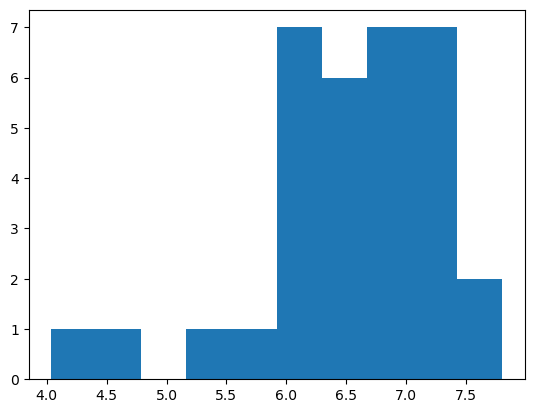

In [24]:
plt.hist(x=mrg_hp_use_dropna["행복지수"])    # 히스토그램으로 판단

<AxesSubplot:>

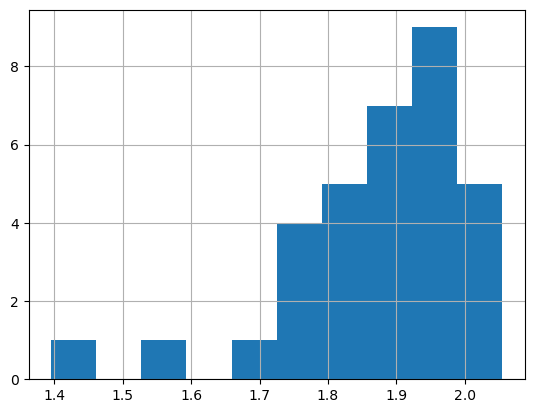

In [31]:
np.log(mrg_hp_use_dropna["행복지수"]).hist()   # log 함수로 왜도를 줄여보고자 함

In [29]:
# 취미 시간과 행복 지수의 상관관계를 파악하고, 상관성 검증

X = mrg_hp_use_dropna["분(min)"]
y = mrg_hp_use_dropna["행복지수"]

X = sm.add_constant(X, has_constant="add")

model = sm.OLS(y, X)
result_model = model.fit()
result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   행복지수   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     10.72
Date:                Sun, 28 May 2023   Prob (F-statistic):            0.00260
Time:                        20:45:06   Log-Likelihood:                -34.330
No. Observations:                  33   AIC:                             72.66
Df Residuals:                      31   BIC:                             75.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8215      0.834      4.580      0.000       2.120       5.523
분(min)         0.0047      0.001      3.275      0.003       0.002       0.008
==============================================================================
Omnibus:                       14.965   Durbin-Watson:                   0.651
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.512
Skew:                          -1.344   Prob(JB):                     0.000260
Kurtosis:                       5.186   Cond. No.                     3.97e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
mrg_hp_use2 = pd.merge(happy_world, timeUse_oecd_gr, how="outer", left_on="국가", right_on="국가")
mrg_hp_use2

,순위,국가,행복지수,분류,분(min)
0,1,핀란드,7.804,Leisure,662.343630
1,1,핀란드,7.804,Other,85.128215
2,1,핀란드,7.804,Paid work or study,458.450750
3,1,핀란드,7.804,Personal care,1280.843020
4,1,핀란드,7.804,Unpaid work,393.234390
...,...,...,...,...,...
264,133,콩고 민주공화국,3.207,NaN,NaN
265,134,짐바브웨,3.204,NaN,NaN
266,135,시에라리온,3.138,NaN,NaN
267,136,레바논,2.392,NaN,NaN


In [55]:
# mrg_hp_use2[mrg_hp_use2["분류"].isnull()]

,순위,국가,행복지수,분류,분(min)
10,3,아이슬란드,7.530,NaN,NaN
11,4,이스라엘,7.473,NaN,NaN
27,8,스위스,7.240,NaN,NaN
73,18,체코,6.845,NaN,NaN
94,23,코스타리카,6.609,NaN,NaN
...,...,...,...,...,...
264,133,콩고 민주공화국,3.207,NaN,NaN
265,134,짐바브웨,3.204,NaN,NaN
266,135,시에라리온,3.138,NaN,NaN
267,136,레바논,2.392,NaN,NaN


In [57]:
csv_to_excel(mrg_hp_use2, "전처리_행복지수+여가시간2.xlsx")

## <font color=#FFE0C6> 행복수준 </font>

In [ ]:
lev_happiness = pd.read_csv("G:/내 드라이브/취미/행복수준_20230510094831.csv", encoding="cp949")

In [ ]:
lev_happiness = leisure_pretreat(lev_happiness, turnOnAvg=1)
lev_happiness.tail()

In [ ]:
csv_to_excel(lev_happiness, "전처리_카테고리별 행복 수준.xlsx")


## <font color="#FF5675"> 일과 여가 생활 균형 </font>

In [6]:
leisure_bal = pd.read_csv("G:/내 드라이브/취미/일과_여가생활_간_균형_20230510094439.csv", encoding='cp949')

In [7]:
leisure_bal = leisure_pretreat(leisure_bal)
leisure_bal.tail()

,연도별,조사대상,세부조사대상,일에더집중하고있다,일에조금더집중하고있다,다소일에집중하고있다,균형을이루고있다,다소여가에더집중하고있다,여가에조금더집중하고있다,여가에더집중하고있다
65,2021,가구소득별,200~300만원,53,204,285,599,154,107,12
66,2021,가구소득별,300~400만원,45,267,401,802,227,134,15
67,2021,가구소득별,400~500만원,38,211,317,708,231,96,6
68,2021,가구소득별,500~600만원,22,178,255,630,197,92,6
69,2021,가구소득별,600만원 이상,41,231,361,735,247,103,6


In [8]:
leisure_bal = leisure_bal.melt(id_vars=["연도별", "조사대상", "세부조사대상"], \
                 value_vars=["일에더집중하고있다", "일에조금더집중하고있다", "다소일에집중하고있다",\
                             "균형을이루고있다", "다소여가에더집중하고있다", "여가에조금더집중하고있다", \
                                "여가에더집중하고있다"], var_name="평가항목", value_name="응답인원")

In [9]:
csv_to_excel(leisure_bal, "전처리_일과 여가생활 균형.xlsx")

## <font color="#FFD73C"> 평일 여가 활동_관광 활동 </font>

In [ ]:
trip = pd.read_csv("G:/내 드라이브/취미/평일에_참여한_여가활동_만족도_관광활동_20230510095154.csv", encoding="cp949")
# trip.info()
# trip.head()

In [ ]:
trip = leisure_pretreat(trip, input_cat="관광")
trip.tail()

## <font color="#FFD73C"> 평일 여가 활동_문화예술 관람 활동 </font>

In [ ]:
artCult = pd.read_csv("G:/내 드라이브/취미/평일에_참여한_여가활동_만족도_문화예술_관람활동_20230519170721.csv", encoding="cp949")
artCult.head()

In [ ]:
artCult = leisure_pretreat(artCult, input_cat="문화 예술 관람")
artCult.head()

## <font color="#FFD73C"> 평일 여가 활동_사회 및 기타 </font>

In [ ]:
sc_etc = pd.read_csv("G:/내 드라이브/취미/평일에_참여한_여가활동_만족도_사회_및_기타활동_20230510093021.csv", encoding="cp949")

In [ ]:
sc_etc = leisure_pretreat(sc_etc, input_cat="사회 및 기타")
sc_etc.tail()

## <font color="#FFD73C"> 평일 여가 활동_스포츠 참여 활동 </font>

In [ ]:
doSports = pd.read_csv("G:/내 드라이브/취미/평일에_참여한_여가활동_만족도_스포츠_참여활동_20230510095111.csv", encoding="cp949")

In [ ]:
doSports = leisure_pretreat(doSports, input_cat="스포츠 참여")
doSports.tail()

## <font color="#FFD73C"> 평일 여가 활동_스포츠 관람 활동 </font>

In [ ]:
wacthSports = pd.read_csv("G:/내 드라이브/취미/평일에_참여한_여가활동_만족도_스포츠_관람활동_20230519170812.csv", encoding="cp949")

In [ ]:
wacthSports = leisure_pretreat(wacthSports, input_cat="스포츠 관람")
wacthSports.head()

## <font color="#FFD73C"> 평일 여가 활동_취미 오락 활동 </font>

In [ ]:
games = pd.read_csv("G:/내 드라이브/취미/평일에_참여한_여가활동_만족도_취미・오락활동_20230510092915.csv", encoding="cp949")

In [ ]:
games = leisure_pretreat(games, input_cat="취미 오락")
games.tail()

## <font color="#FFD73C"> 평일 여가 활동_휴식 활동 </font>

In [ ]:
takeArest = pd.read_csv("G:/내 드라이브/취미/평일에_참여한_여가활동_만족도_휴식활동_20230510092941.csv", encoding="cp949")

In [ ]:
takeArest = leisure_pretreat(takeArest, input_cat="휴식")
takeArest.tail()

## 평일 여가 활동 합치기

In [ ]:
allLeisure = pd.concat([trip, artCult, sc_etc, doSports, wacthSports, games, takeArest], axis=0)
allLeisure.reset_index(drop=True, inplace=True)
print("전체 행 길이 :", len(allLeisure[:]))
allLeisure.head()

In [ ]:
allLeisure = allLeisure.melt(id_vars=['연도별', '여가종류', "조사대상", "세부조사대상"], \
                             value_vars=["매우불만족한다", "불만족한다", "다소불만족한다", "보통이다", "다소만족한다", "만족한다", "매우만족한다"], \
                            var_name='평가항목', value_name='응답인원')
print("전체 행 길이 :", len(allLeisure[:]))
allLeisure.head()

In [ ]:
csv_to_excel(allLeisure, "전처리_평일 여가 활동.xlsx")

## <font color="#C1FF6B	"> 지난 1년 동안 지속적 반복적 참여 </font>

In [6]:
rep_per_year = pd.read_csv("G:/내 드라이브/취미/_지난_1년_동안__지속적_반복적_참여_여가활동_여부_20230510095327.csv", encoding="cp949")

In [7]:
rep_per_year = leisure_pretreat(rep_per_year)

In [8]:
rep_per_year.head()

,연도별,조사대상,세부조사대상,있음,없음
0,2016,연령별,15~19세,375,451
1,2016,연령별,20대,764,711
2,2016,연령별,30대,826,880
3,2016,연령별,40대,1013,977
4,2016,연령별,50대,1003,952


In [13]:
rep_per_year = rep_per_year.melt(id_vars=["연도별", "조사대상", "세부조사대상"], value_vars=["있음", "없음"], var_name="여부", value_name="응답인원")

In [ ]:
csv_to_excel(rep_per_year, "전처리_1년간 지속반복 참여.xlsx")

## <font color="#00D7FF	"> 보다 나은 여가 생활 </font>

In [ ]:
btr_leisure = pd.read_csv("G:/내 드라이브/취미/정책만족도_보다_나은_여가생활을_위해_관련_법규와_제도를_개선_20230510094233.csv", encoding="cp949")

In [ ]:
btr_leisure = leisure_pretreat(btr_leisure, turnOnAvg=1)

In [ ]:
csv_to_excel(btr_leisure, "전처리_정책 개선 후 여가 생활 만족도.xlsx")

## <font color="#90AFFF"> 근로시간 단축 이후 </font>

In [ ]:
cut_worktime = pd.read_csv("G:/내 드라이브/취미/근로시간_단축_이후_여가만족도_20230510094931.csv", encoding="cp949")

In [ ]:
cut_worktime = leisure_pretreat(cut_worktime, turnOnAvg=1, choice_yr=2019)

In [ ]:
csv_to_excel(cut_worktime, "전처리_근로시간 단축 후 여가만족도.xlsx")

## <font color="#68269A"> 여가 생활 불만족 </font>

In [6]:
unsat_leis = pd.read_csv("G:/내 드라이브/취미/여가생활에_만족하지_못하는_이유_20230525113739.csv", encoding="cp949")

In [7]:
unsat_leis = leisure_pretreat(unsat_leis)

In [10]:
unsat_leis.head()

,연도별,조사대상,세부조사대상,이유,응답인원
0,2016,연령별,15~19세,시간이부족하여,332
1,2016,연령별,20대,시간이부족하여,334
2,2016,연령별,30대,시간이부족하여,478
3,2016,연령별,40대,시간이부족하여,530
4,2016,연령별,50대,시간이부족하여,462


In [9]:
unsat_leis = unsat_leis.melt(id_vars=["연도별", "조사대상", "세부조사대상"], \
                value_vars=["시간이부족하여", "경제적부담때문에", \
                            "여가정보및프로그램이부족하여", "여가를함께즐길사람이없어서",	\
                                "이전경험이부족해서", "여가시설이부족하여", "기타"], \
                                    var_name="이유", value_name="응답인원")

In [ ]:
csv_to_excel(unsat_leis, "전처리_여가 생활 만족 못 하는 이유.xlsx")

## <font color="#82B3ED"> OECD 평균 근로시간 </font>

In [ ]:
avg_workt_oecd = pd.read_csv("G:/내 드라이브/취미/ANHRS_25052023055022396.csv", sep="\t", encoding="cp949")

In [ ]:
avg_workt_oecd.rename({"Value":"hours"}, axis=1, inplace=True)

In [ ]:
avg_workt_oecd = avg_workt_oecd[avg_workt_oecd["Employment status"] == "Total employment"]

In [ ]:
avg_workt_oecd.reset_index(drop=True, inplace=True)
avg_workt_oecd.columns = ["국가", "전체 고용", "연도", "시간(hr)"]
avg_workt_oecd.head()

In [ ]:
avg_workt_oecd.replace(List_country, List_country_korean, inplace=True)
avg_workt_oecd["국가"].unique()

In [ ]:
avg_workt_oecd = avg_workt_oecd[avg_workt_oecd["국가"]!='OECD countries']
avg_workt_oecd['국가'].unique()

In [ ]:
List_country2 = ['Czech Republic', 'Iceland', 'Slovak Republic', 'Switzerland', 'Israel', 'Chile', 'Costa Rica', 'Colombia']
List_country_korean2 = ['체코', '아이슬란드', '슬로바키아', '스위스', '이스라엘', '칠레', '코스타리카', '콜롬비아']

In [ ]:
avg_workt_oecd.replace(List_country2, List_country_korean2, inplace=True)
avg_workt_oecd["국가"].unique()

In [ ]:
csv_to_excel(avg_workt_oecd, "전처리_OECD 평균 근로시간.xlsx")

# 일과 여가 생활 균형_연습버전

In [ ]:
leisure = pd.read_csv("G:/내 드라이브/취미/일과_여가생활_간_균형_20230510094439.csv", encoding='cp949')
# leisure.info()
# leisure.head(10)

In [ ]:
leisure_T = leisure.T   # 행열 전환
# leisure_T.head(5)

In [ ]:
leisure_T.replace("-",0,inplace=True)

In [ ]:
leis_uq = leisure.iloc[:,0].unique()
leis_uq = leis_uq.tolist()   # ndarray -> list
leis_uq = [re.sub(r"\(+.\)","",uq.replace(" ","_")) for uq in leis_uq]  # 괄호와 괄호 안 글자, 공백 제거
print(leis_uq)

In [ ]:
leisure_T.columns = leisure_T.iloc[0,:]
# leisure_T.info()

In [ ]:
columns_nospace = [re.sub(r"\(+.\)", "", col.replace(" ","_")) for col in leisure_T.columns]

In [ ]:
leisure_T.columns = columns_nospace
print(leisure_T.columns)

In [ ]:
# 통계 분류별로 데이터 프레임 분류

for cat in leis_uq : 
    globals()["leisure_{}".format(cat)] = leisure_T[cat]
    
    if type(globals()["leisure_{}".format(cat)]) == pd.core.series.Series :   # type이 시리즈라면
        globals()["leisure_{}".format(cat)] = pd.DataFrame(globals()["leisure_{}".format(cat)])   # 시리즈를 데이터프레임으로 변경
        
    globals()["leisure_{}".format(cat)].columns = globals()["leisure_{}".format(cat)].iloc[1,:]
    globals()["leisure_{}".format(cat)] = globals()["leisure_{}".format(cat)].iloc[2:,:]
    globals()["leisure_{}".format(cat)].iloc[:,1:] = globals()["leisure_{}".format(cat)].iloc[:,1:].astype(float)

In [ ]:
leis_uq2 = leis_uq[1:]
print(leis_uq2)

In [ ]:
for uq2 in leis_uq2 : 
    globals()["leis_{0}_{1}".format(uq2, "합본")] = pd.concat([leisure_통계분류, globals()["leisure_{}".format(uq2)]],axis=1)

In [ ]:
for uniq in leis_uq2 : 
    idx_List = globals()["leis_{0}_{1}".format(uniq, "합본")].index.to_list()   # 분리된 데이터프레임 인덱스 리스트로 반환
    
    for yr in year_List : 
        sep_year = []    # 정규표현식에 만족하는 인덱스를 저장할 리스트
        
        for idx in idx_List :
            find_yr = re.findall(str(yr)+"[.0-9]*",idx)     # 연도 + '.' or 숫자 1개 이상 포함돼 있는 인덱스 저장 

            if find_yr:      # 빈 리스트가 아니라면 (findall은 조건에 안 맞으면 빈 리스트 반환)
                sep_year.append(find_yr[0])

        Last_idx = len(sep_year)
        globals()["leis_{0}_{1}".format(uniq, str(yr))] = globals()["leis_{0}_{1}".format(uniq, "합본")][:][sep_year[0]:sep_year[Last_idx-1]]    # 행 인덱스로 슬라이싱, 행 인덱스로 슬라이싱할 때 콜론 뒤 값을 포함해서 슬라이싱한다.
        pattern = str(yr) + r'[.0-9]*'
        new_index = globals()["leis_{0}_{1}".format(uniq, str(yr))].index.map(lambda x: re.sub(pattern, str(yr), x))   # map 함수를 이용해 인덱스마다 정규 표현식 sub를 적용
        globals()["leis_{0}_{1}".format(uniq, str(yr))].index = new_index
        globals()["leis_{0}_{1}".format(uniq, str(yr))].index = globals()["leis_{0}_{1}".format(uniq, str(yr))].index.astype(int)   # 인덱스를 int 타입으로
        globals()["leis_{0}_{1}".format(uniq, str(yr))].rename(columns={"통계분류(2)" : "분류"}, inplace=True)   # 컬럼명 변경
        globals()["leis_{0}_{1}".format(uniq, str(yr))] = globals()["leis_{0}_{1}".format(uniq, str(yr))].reset_index()   # reset_index
        globals()["leis_{0}_{1}".format(uniq, str(yr))].rename(columns={"index" : "연도"}, inplace=True)    # 인덱스가 컬럼으로 바뀌고, 그 컬럼명을 변경
        globals()["leis_{0}_{1}".format(uniq, str(yr))] = globals()["leis_{0}_{1}".format(uniq, str(yr))].set_index(["연도","분류"])   # 멀티 인덱스 설정


# 전체 -> 리스트 중에서 2016년이면 리스트에 저장 -> 리스트에 저장된 첫번째와 마지막 인덱스로 슬라이싱 -> 새로운 데이터 프레임 생성

In [ ]:
leis_17개_시도별_2016_T = leis_17개_시도별_2016.T
leis_17개_시도별_2016_T.head(10)

In [ ]:
df = leis_17개_시도별_2016_T.stack(level=0)
pd.DataFrame(df)


In [ ]:
pd.concat([leis_17개_시도별_2016, leis_가구소득별_2016],axis=1)

## PDF 불러오기

In [ ]:
import fitz
path1 = "G:/내 드라이브/취미/세계행복보고서_2023.pdf"

In [ ]:
doc = fitz.open(path1)

pages = list(range(36,39))

count = 0

for page in doc : 
    
    count += 1

    if count in pages : 
        globals()['text_wrd_hap'+str(count)] = page.get_text()
        globals()['text_wrd_hap'+str(count)] = globals()['text_wrd_hap'+str(count)].split("\n")

doc.close()

In [ ]:
for pg in pages : 
    length = len(globals()['text_wrd_hap'+str(pg)])
    print("리스트의 길이 :", length)
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    print("리스트 앞에 4개의 원소 :", globals()['text_wrd_hap'+str(pg)][:10])
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-")
    print("끝에서 3개의 원소 :", globals()['text_wrd_hap'+str(pg)][-10:])
    print("\n\n")